# CosmoSIS Cosmology Forecasts from OM10 Lensed Quasar Time Delays

*LSST DESC Hack Day, October 30 2015, Argonne National Lab*

David Finley, Elise Jennings, Phil Marshall

## Getting set up

CosmoSIS is a framework for running cosmological parameter inference code. You can install it by following [the instructions on the CosmoSIS wiki](https://bitbucket.org/joezuntz/cosmosis/wiki/Home).

To carry out a calculation with CosmoSIS, you write an "`ini`" file that describes the likelihoods you want to include, the priors you want to assign, and which sampler you want to use. You then run 
```
    cosmosis file.ini
```
from the command line. It seems that you have to be using the `bash` shell for this, and so I recommend doing the CosmoSIS calculations in one shell, while running this notebook from another (so that your python environment is preserved). 

We will need a set of CosmoSIS `.ini` files written so that `cosmosis` can be run from the OM10 examples folder, like this:
```
cd examples/LSST
bash
export COSMOSIS_SRC_DIR = /Users/pjm/work/stronglensing/LSST/DESC/Cosmology/cosmosis
source ${COSMOSIS_SRC_DIR}/config/setup-cosmosis
```

This results in a `bash` shell, configured for running `cosmosis`. 

## Making Mock Data

Let's select a plausible sample of LSST lensed quasars from the OM10 catalog. Here are some sensible selection criteria:
```python
maglim = 22.0   # Faintest image must be well detected
area = 18000.0  # LSST WFD survey area (sq deg)
IMSEP > 1.0     # Well-resolved (!) quasar images (arcesec)
APMAG_I < 21.0  # Bright lenses, for velocity disp. measurement
DELAY > 10.0    # Longish time delays (days)
```

Let's fire up an OM10 catalog instance and make this selection.

In [6]:
import om10
import os, numpy as np

In [10]:
db = om10.DB(catalog=os.path.expandvars("$OM10_DIR/data/qso_mock.fits"))

db.select_random(maglim=22.0,area=18000.0,IQ=0.75)

good = db.sample[np.where(\
        (db.sample['IMSEP'] > 1.0) * \
        (db.sample['APMAG_I'] < 21.0) * \
        (np.max(db.sample['DELAY'],axis=1) > 10.0))]
print "Number in cosmography sub-sample:",len(good)

om10.DB: selection yields  1116  lenses
Number in cosmography sub-sample: 432


Now let's write out a list of $(z_d, z_s)$ pairs - this will be the input to the time delay lens mock data generation module in CosmoSIS.

In [18]:
output = 'zd_zs.txt'
data = np.array([good['ZLENS'],good['ZSRC']]).T
print data.shape
np.savetxt(output,data)
! wc -l $output

(432, 2)
     432 zd_zs.txt


From here on, we'll use the data file that is checked in:  `OM10_LSSTDESC_zd_zs.txt`. This will make comparisons easier. It contains 466 mock lenses' $(z_d,z_s)$ pairs.

We used [Suyu et al (2010)](http://arxiv.org/pdf/0910.2773.pdf) to create a CosmoSIS module to take $(z_d, z_s)$ from above and append mock observations $(D_{\Delta t}, \sigma_{\Delta t})$. We assumed $\sigma_{\Delta t} = 0.05$ (5% precision per lens). The time delay distance "data" are drawn from a lognormal sampling distribution, as used by Suyu et al. We used an offset ($\lambda_D$) of 0.0, though, to allow all lenses to be treated the same way. We need to check that this does actually give plausible sampling distributions, but for now, let's carry on.

We run the mock data generation module with the following `ini` file:
```
    cosmosis OM10_LSSTDESC_generate.ini
```
Let's look at this file.

In [20]:
# %load OM10_LSSTDESC_generate.ini

This CosmoSIS run results in a new 466-row plain text data file, with 4 columns: `OM10_LSSTDESC_mock_data.txt`

## Inferring cosmological parameters

We extended the CosmoSIS module for time delay distance cosmography in the `develop` branch. To sample the joint cosmological parameter posterior PDF given our mock time delay distance data, we use a different `ini` file:

```
	cosmosis OM10_LSSTDESC_inference.ini
```

The output is saved as `OM10_LSSTDESC_inferred_parameters.txt`, and the run takes a few minutes.

Let's take a look at this `ini` file:

In [21]:
# %load OM10_LSSTDESC_inference.ini

The `postprocess` script can be used to make some standard-format plots of the MCMC-sampled posterior PDF, marginalized to 1 and 2D.
```
postprocess  --burn 5000 -o OM10_LSSTDESC_plots -p OM10_LSSTDESC_inferred OM10_LSSTDESC_inference.ini
```
This produces a lot of plots in a new folder, `OM10_LSSTDESC_plots`. To view them all (on a Mac), do
```
open OM10_LSSTDESC_plots/OM10_LSSTDESC_inferred_*.png
```

Compressed 1D marginalized parameter inferences can be read from one of the files in the plots folder, eg,
```
more OM10_LSSTDESC_inferred_means.txt

# parameter mean std_dev
# OM10_LSSTDESC_inferred_parameters.txt
cosmological_parameters--omega_m   5.673062e-01   1.784710e-01
cosmological_parameters--h0   7.130534e-01   6.988178e-03
cosmological_parameters--omega_b   4.199131e-02   1.098027e-02
cosmological_parameters--omega_k   -2.133684e-05   1.641963e-04
cosmological_parameters--w   -9.135106e-01   2.050209e-01
cosmological_parameters--wa   -6.870567e-03   2.631039e-01
like   -inf   nan
```

- The `omega_m` PDF is broad, but does seem to be shifted somewhat to higher values (0.57 +/- 0.18) - we should re-run with a different sample and check this. 
- The Hubble constant `h` (0.713 +/- 0.007) is possibly also shifted low (but less significantly). Nice to see 1% precision even with freely varying curvature and Dark Energy parameters. 
- Likewise, nice to see `omega_k` come out to be (-0.00002 +/- 0.00016) (very high precision!), and the Dark Energy parameters inferred from strong lensing alone (albeit with precision +/-0.2 in `w0` and +/-0.26 `wa`).  
- It's possible that the `omega-m` bias (if it's real) is a result of mismatched sampling distribution (when generating data) and likelihood; it could also just be a phase space effect, from the large uniform prior volume in the other parameters. 

Let's make a *corner plot* showing all 1 and 2D marginalized posterior PDFs - and let's do a visual check for MCMC chain convergence too

In [43]:
import corner
%matplotlib inline

samples = np.loadtxt('OM10_LSSTDESC_inferred_parameters.txt')

In [59]:
# Let's remove the -inf likelihood  samples:
index = np.any(~np.isneginf(samples),axis=1)
p = samples[index,:]
p.shape

(25600, 7)

In [63]:
Om, Om_range, Om_true = p[:,0], (0.0,1.0),   0.3
h, h_range, h_true    = p[:,1], (0.65,0.75), 0.7
Ob, Ob_range, Ob_true = p[:,2], (0.02,0.06), 0.04 
Ok, Ok_range, Ok_true = p[:,3], (-0.02,0.02),0.0
w0, w0_range, w0_true = p[:,4], (-1.5,-0.5),-1.0
wa, wa_range, wa_true = p[:,5], (-0.5,0.5),  0.0

parameters = np.array([Om,h,Ob,Ok,w0,wa]).T
labels = ['$\Omega_{\\rm m}$','$h$','$\Omega_{\\rm b}$','$\Omega_{\\rm k}$','$w_0$','$w_{\\rm a}']
ranges = [Om_range,h_range,Ob_range,Ok_range,w0_range,wa_range]
truths = [Om_true,h_true,Ob_true,Ok_true,w0_true,wa_true]

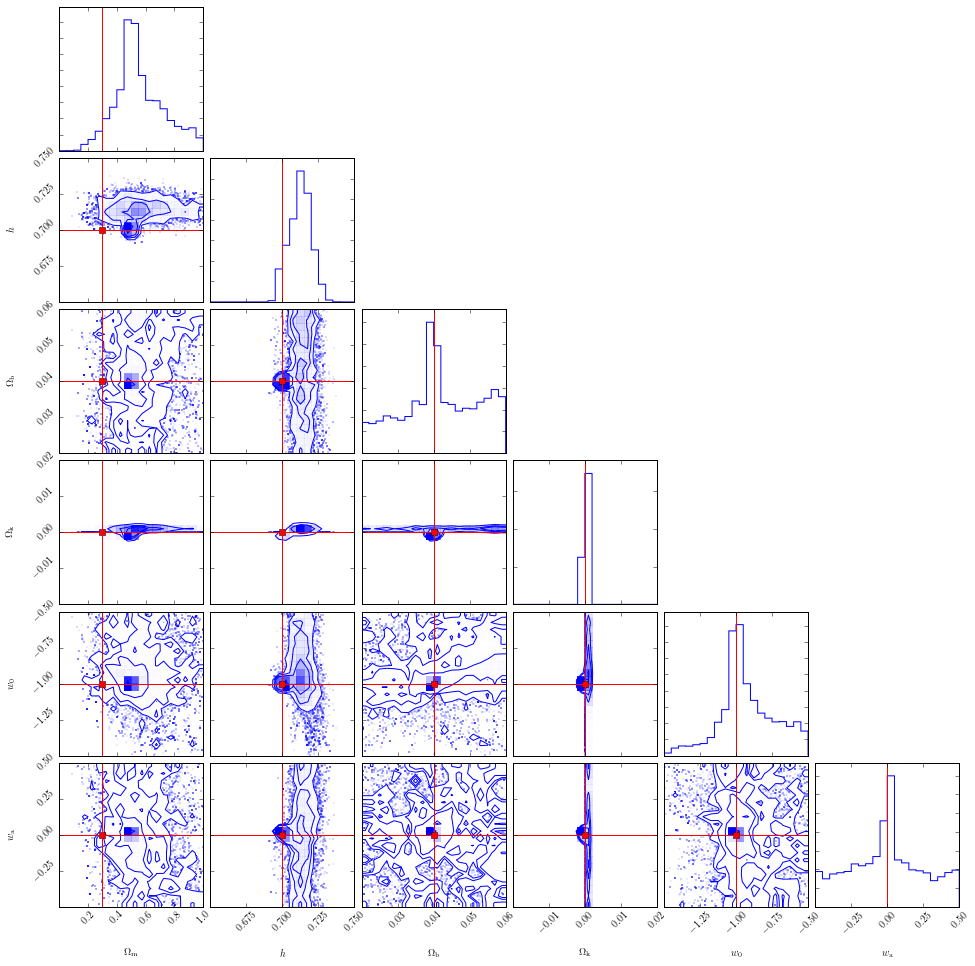

In [65]:
burnin = 2000

fig = corner.corner(parameters[burnin:,:],labels=labels,range=ranges,truths=truths,color='blue',truth_color='red')

## Next Steps

- The sampling does not look converged: there are some odd looking features in the posterior PDF. Is it multimodal, with several sharp peaks? Or is the sampler failing to cope with the difference in precision across the parameter set? We could try first running Minuit to find the peak and approximate the posterior with a multivariate Gaussian, and then MCMC sampling starting from that approximation.

- We need to check that using $\lambda_D = 0.0$ gives reasonable sampling distributions for our distances. Suyu et al needed a much higher offset, so that the shape of the PDF came out right. *Probably* an unoffset lognormal is OK, but let's make some simple test plots with different $\lambda$ values and see how they look.

- It would be interesting to do a run with the Planck likelihood included, to see how much we can learn about the Dark Energy parameters from CMB + time delay lenses. And then of course we'd like to see how SL interacts with the other probes in a DESC-wide forecast.

## Issues

- PJM wrote two `cosmosis` issues about 1) [the samples with `-inf` log likelihood being accepted by `emcee` and then used by `postprocess`](https://bitbucket.org/joezuntz/cosmosis/issues/119/do-emcee-and-postprocess-deal-correctly), and 2) [the contents (header line? credible intervals?) of the `medians.txt` file.](https://bitbucket.org/joezuntz/cosmosis/issues/118/medians-file-contains-incorrect-header)